# Druglikeness - Introduction

In the previous notebook, we played with the concept of molecular descriptors, and compared our sets of known ligands to known therapeutic drugs contained in the DrugBank database, using several common descriptors. This already gave you some information on how do your selected ligands compare to known drugs.

While we can compare the two sets any which way, there are also some widely established rules of thumb for identifying [drug-like](https://en.wikipedia.org/wiki/Druglikeness) structures, i.e. small molecules that have a chance to be reasonably potent, selective, and, above all, able to reach the therapeutic target (receptor) when [ingested](https://en.wikipedia.org/wiki/Bioavailability). Nobody wants to inject their medication into theirs veins, unless absolutely necessary. More on biological availability [here](http://howmed.net/pharmacology/bioavailability-of-drugs/).

The most known set of rules for biological availability is the Lipinski's [rule of five](https://en.wikipedia.org/wiki/Lipinski%27s_Rule_of_Five) (LRO5). It states that molecules can be expected to have good bioavailability when:
 - no more than 5 hydrogen bond donors
 - no more than 10 hydrogen bond acceptors
 - molecular weight of less than 500 Da
 - logP less than 5

The above are just general rules of thumb, to avoid excesively large, greasy molecules that would have serious problems getting to the target in a real organism. In most applications, molecules that violate only one of the aforedescribed rules still get a passing mark. A more complex insight on LRO5 can be read [here](https://blogs.sciencemag.org/pipeline/archives/2005/02/14/bigger_and_greasier). I would recommend reading dr. Lowe's stuff in general to get some idea about drug discover/development from pharma chemist's perspective. Since there is no sense of me reiterating anymore of what is already readily available on your materials from lectures and also from Wikipedia, let's try and implement this filter on our own:

# Learning objectives
 - Have a look at Lipinski and other filters, linked in the workflow
 - Implement the rules, either as done here, or by other methods of your preference. Please try not to just copypaste the solution, and make sure that you understand what is being done. I can't freeze frame the classroom projector here, so honor system only :)
 - Run the filters on your set, evaluate the results, compare with MTOR results, and with DrugBank
 - How many ligands in your set fail the filters, what is their ratio?
 - What rules are the most frequently failed ones? 
 - How does the absolute numbers, as well as failure rate of individual rules compare to MTOR ligands and DrugBank?
 - Finally, to not just copypaste code, also look at lead-likeness filter, which is even more stringent than drug-likeness one (LogP 3 or less, molecular weight below 300 Da, max 3 HBA, max 3 HBD, and no more than 3 rotatable bonds). It is more strict so that there is some extra space for pharmaceutical lead to be further developed for specificity and/or potency by adding additional groups without the molecule getting too large and greasy. Implement this filter much like the Lipinski or Ghose one, and perform the corresponding visualizations. How many of your known ligands have lead-like properties that would make them good candidates for further drug development? How do the already developed drugs in DrugBank fare against your filter?

# A story of cytochrome P450

In [88]:
# just the usual housekeeping, import libraries, load ligand and DrugBank data
# you load your own set, and DrugBank :)
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import IPythonConsole
import csv

# loading cytochrome data
with open('Cytochrome_P450_targets.csv', 'r') as file:
    csv_reader = csv.DictReader(file, delimiter=";")
    cyt_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in csv_reader]

# loading mtor data
with open('../data/chembl_mtor_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    mtor_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

# loading drugbank    
suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [12:22:12] ERROR: Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [12:22:38] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [12:22:38] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [12:22:38] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [12:22:38] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [12:22:38] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [12:22:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [12:22:39] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [12:22:39] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [12:22:39] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [12:22:39] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [12:22:39] ERROR: Explicit v

## Lipinski's rules

There are many ways to implement a Lipinski filter, since it is just a value cutoff. But, we might as well get fancy and implement it using functions. You can do whichever way you prefer :)

In [89]:
# no more than 5 hydrogen bond donors
def too_many_hbd(mol):
    # takes an RDKit mol instance, returns True if the structure is out of LRO5 bounds
    return rdescriptors.CalcNumLipinskiHBD(mol) > 5

# no more than 10 hydrogen bond acceptors
def too_many_hba(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 10

# molecular weight of less than 500 Da
def too_heavy(mol):
    return rdescriptors.CalcExactMolWt(mol) > 500

# logP less than 5
def too_greasy(mol):
    return Descriptors.MolLogP(mol) > 5

Let's select some structures from our set, and try to apply our filters:

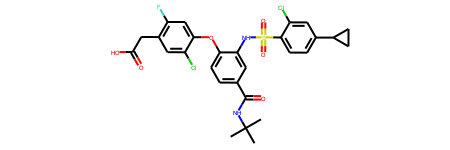

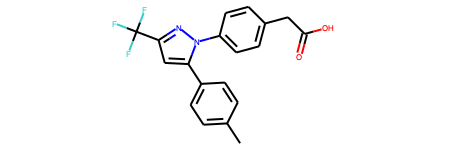

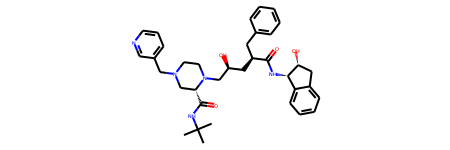

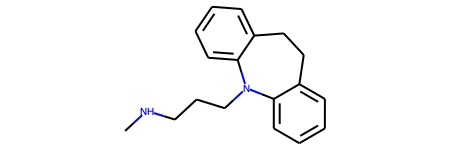

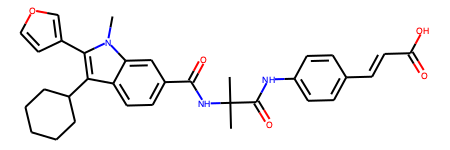

In [90]:
for i in range(105,110):
    display(cyt_ligands[i])

In [91]:
# and see how the structure fares
print('ID ', ' HBD ', ' HBA ', ' heavy', 'greasy')
for i in range(105,110):
    print(f'{i} ', too_many_hbd(cyt_ligands[i]), too_many_hba(cyt_ligands[i]), too_heavy(cyt_ligands[i]), too_greasy(cyt_ligands[i]))

ID   HBD   HBA   heavy greasy
105  False False True True
106  False False False False
107  False False True False
108  False False False False
109  False False True True


So, 2 Lipinski red flags for our 105 and 109 ligands and Lipinski flag for structure 107. 106 and 108 seem to be biologically available.

Let's evaluate the whole ligand set :)

In [92]:
# evaluation of cytochrome ligand set
cyt_ligands_too_many_hbd = [too_many_hbd(l) for l in cyt_ligands]
cyt_ligands_too_many_hba = [too_many_hba(l) for l in cyt_ligands]
cyt_ligands_too_heavy = [too_heavy(l) for l in cyt_ligands]
cyt_ligands_too_greasy = [too_greasy(l) for l in cyt_ligands]
sum(cyt_ligands_too_many_hbd), sum(cyt_ligands_too_many_hba), \
sum(cyt_ligands_too_heavy), sum(cyt_ligands_too_greasy), len(cyt_ligands)

(94, 223, 1093, 1198, 5841)

So, from this crude view on data, it looks like most of the 5841 molecules within this data set pass the RO5. The biggest problem seems to be that over thousand of the molecules seem too heavy and too greasy. Let's make the data look a bit nicer:

In [93]:
import pandas as pd
df = pd.DataFrame(data={'set':'cytochrome P450',
                        'too_many_hbd': cyt_ligands_too_many_hbd,
                        'too_many_hba': cyt_ligands_too_many_hba,
                        'too_greasy': cyt_ligands_too_heavy,
                        'too_heavy': cyt_ligands_too_greasy})
df

,set,too_many_hbd,too_many_hba,too_greasy,too_heavy
0,cytochrome P450,False,False,False,False
1,cytochrome P450,False,False,False,False
2,cytochrome P450,False,False,False,False
3,cytochrome P450,False,False,False,False
4,cytochrome P450,False,False,False,False
...,...,...,...,...,...
5836,cytochrome P450,False,False,False,False
5837,cytochrome P450,False,False,False,True
5838,cytochrome P450,False,False,False,True
5839,cytochrome P450,False,False,False,True


In [94]:
# defining violations functions
def ro5_violations(mol):
    # takes RDKit mol, return how many rules it actually violates
    return sum([too_many_hbd(mol), too_many_hba(mol), too_heavy(mol), too_greasy(mol)])

def violates_lipinski(mol):
    # checks the number of RO5 violations, if they are more than one, return True
    return ro5_violations(mol) > 1

In [95]:
# let's apply those functions on our data set:
cyt_ro5_violations = [ro5_violations(l) for l in cyt_ligands]
cyt_violates_lipinski = [violates_lipinski(l) for l in cyt_ligands]
print(sum(cyt_ro5_violations),\
round(sum(cyt_ro5_violations)/len(cyt_ro5_violations),2), '%',\
sum(cyt_violates_lipinski),\
round(sum(cyt_violates_lipinski)/len(cyt_violates_lipinski),2), '%')

2608 0.45 % 680 0.12 %


So, the overall amount of RO5 violations in the my data set seems to be 2608, which is about half RO5 violations per molecule. 680 ligands, which is about 11%, violate more than one LRO5 rule, and thus fail the standard Lipinski filter. 
let's add the lipinski pass data into the dataframe and visualize it:

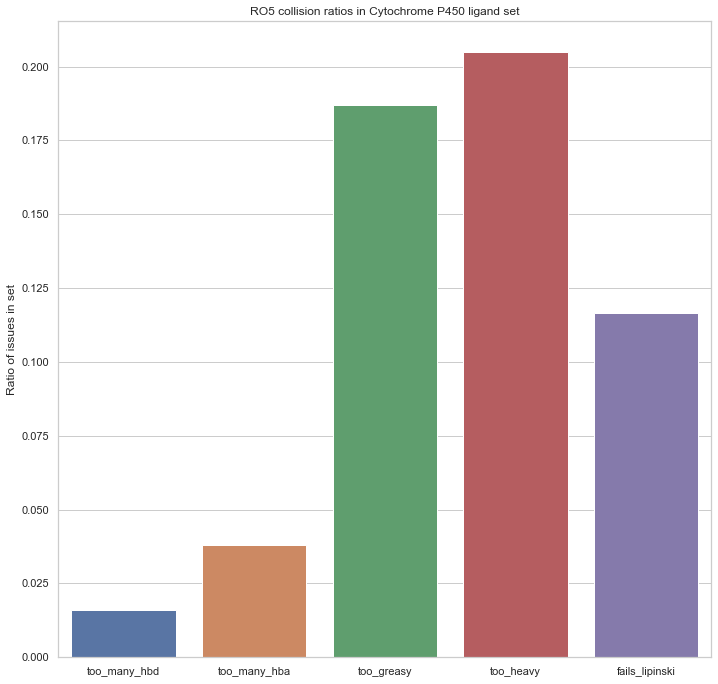

In [96]:
df['fails_lipinski'] = cyt_violates_lipinski
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("RO5 collision ratios in Cytochrome P450 ligand set")
    p.set_ylabel("Ratio of issues in set")

## Ghose extention & Verber's rule

Cool. Still, [Lipinski](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five) is not the only filter in town. To get a more comprehensive picture, let's implement some more, to get a more comprehensive picture. Let's do the Ghose extension that remaps the requirements for logP and molecular weight, and instead of HBA and HBD uses molar refractivity and number of atoms. Also the Veber's rule on rotatable bonds and polar surface area:

In [97]:
from rdkit.Chem import Crippen

# ghose extentions
# greasiness
def bad_greasyness_ghose(mol):
    logp = Descriptors.MolLogP(mol)
    return logp > 5.6 or logp < -0.4

# let's apply the filters and add them to the dataframe as we go
df['odd_greasyness'] = [bad_greasyness_ghose(l) for l in cyt_ligands]

# reactivity
def bad_refractivity_ghose(mol):
    ref = Crippen.MolMR(mol)
    return ref > 130 or ref < 40
df['odd_refractivity'] = [bad_refractivity_ghose(l) for l in cyt_ligands]

# molecular weight
def bad_mw_ghose(mol):
    mw = rdescriptors.CalcExactMolWt(mol)
    return mw > 480 or mw < 180
df['odd_mass'] = [bad_mw_ghose(l) for l in cyt_ligands]

# atom count
def bad_atomcount_ghose(mol):
    ac = mol.GetNumHeavyAtoms()
    return ac > 70 or ac < 20
df['odd_atomcount'] = [bad_atomcount_ghose(l) for l in cyt_ligands]

# violation ghose
def violates_ghose(mol):
    return bad_greasyness_ghose(mol) or bad_refractivity_ghose(mol) or bad_mw_ghose(mol) or bad_atomcount_ghose(mol)
df['fails_ghose'] = [violates_ghose(l) for l in cyt_ligands]

# rotable bonds
def too_rotatable_veber(mol):
    return Chem.CalcNumRotatableBonds(mol) > 10
df['too_rotatable'] = [too_rotatable_veber(l) for l in cyt_ligands]

# large polar surface area (PSA)
def too_large_psa_veber(mol):
    return rdescriptors.CalcTPSA(mol) > 140
df['excessive_psa'] = [too_large_psa_veber(l) for l in cyt_ligands]

# violation PSA
def violates_veber(mol):
    return too_rotatable_veber(mol) or too_large_psa_veber(mol)
df['fails_veber'] = [violates_veber(l) for l in cyt_ligands]

... And visualize our masterpiece :)

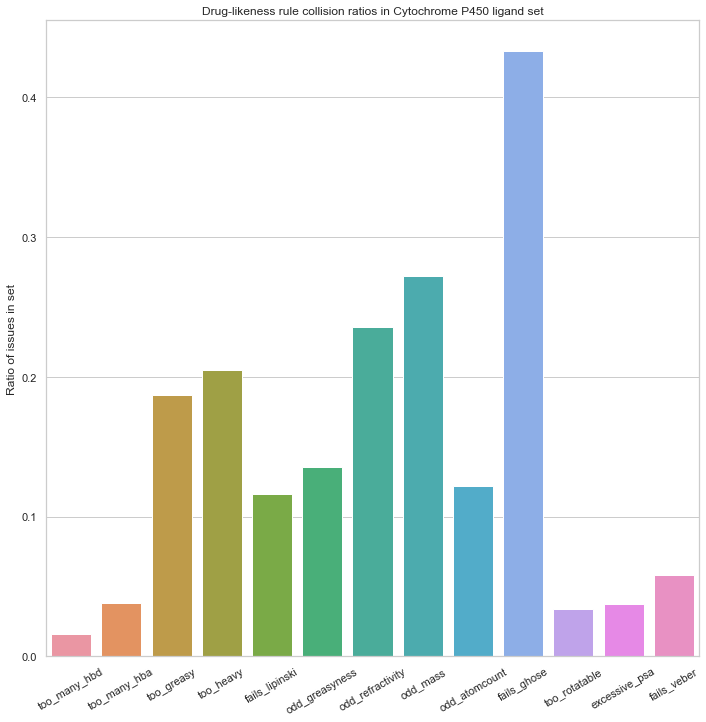

In [98]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("Drug-likeness rule collision ratios in Cytochrome P450 ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) # avoid ugly text clipping

## *MTOR conclusion - Lepinski, Veber* 
All right, this should be enough :) So, almost half of the MTOR ligands fail Ghose filter, on bad molar refractivity (i.e. [polarizability](https://en.wikipedia.org/wiki/Polarizability)) and no doubt some on the large size of the molecules, as already shown on the Lipinski RO5 failures. Also, there have to be same light enough to be also clipped by the lower bound of the Ghose molecular mass requirements. As for Veber rules, these apper to be only a little factor, almost no MTOR ligands from the analyzed set have too many rotatable bonds, and only few have too much [polar surface area](https://en.wikipedia.org/wiki/Polar_surface_area), which could give them trouble when getting through cell membranes.

The MTOR set appear quite viable from drug-likeness perspective.

Also, it would be good to put the values in some perspective. Even DrugBank contains some amount of structures that are outside of drug-likeness bounds, some simply because the rules are quite crude tools, others may be substances than can rely on active transport within the organism, and other like [insulin](https://www.drugbank.ca/categories/DBCAT000170) are simply not meant for peroral use.

## *Cytochrome P450 conclusion - Lepinski, Veber*
It seems like almost half of the Cytochrome P450 ligands fail Ghose filter. As was previously shown most molecules are too heavy. In addition, some of the molecules were clipped by the lower bound of Ghose molecular mass requirements. Regarding to Veber's rule, as my ligands do not have a large polar surface area only 5 % of all molecules fail this rule.

Let's get the stats for DrugBank:

In [99]:
df_drugbank = pd.DataFrame(
    data={'set':'DrugBank',
          'too_many_hbd': [too_many_hbd(l) for l in drugs],
          'too_many_hba': [too_many_hba(l) for l in drugs],
          'too_greasy': [too_greasy(l) for l in drugs],
          'too_heavy': [too_heavy(l) for l in drugs],
          'fails_lipinski': [violates_lipinski(l) for l in drugs],
          'odd_greasyness': [bad_greasyness_ghose(l) for l in drugs],
          'odd_refractivity': [bad_refractivity_ghose(l) for l in drugs],
          'odd_mass': [bad_mw_ghose(l) for l in drugs],
          'odd_atomcount': [bad_atomcount_ghose(l) for l in drugs],
          'fails_ghose': [violates_ghose(l) for l in drugs],
          'too_rotatable': [too_rotatable_veber(l) for l in drugs],
          'excessive_psa': [too_large_psa_veber(l) for l in drugs],
          'fails_veber': [violates_veber(l) for l in drugs]})
df_drugbank

,set,too_many_hbd,too_many_hba,too_greasy,too_heavy,fails_lipinski,odd_greasyness,odd_refractivity,odd_mass,odd_atomcount,fails_ghose,too_rotatable,excessive_psa,fails_veber
0,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
1,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
2,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
3,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
4,DrugBank,False,True,False,True,True,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108,DrugBank,False,False,False,False,False,False,True,True,True,True,False,False,False
7109,DrugBank,False,False,False,False,False,True,False,False,False,True,False,True,True
7110,DrugBank,True,True,False,True,True,False,True,True,True,True,True,True,True
7111,DrugBank,False,False,False,False,False,False,False,False,False,False,True,False,True


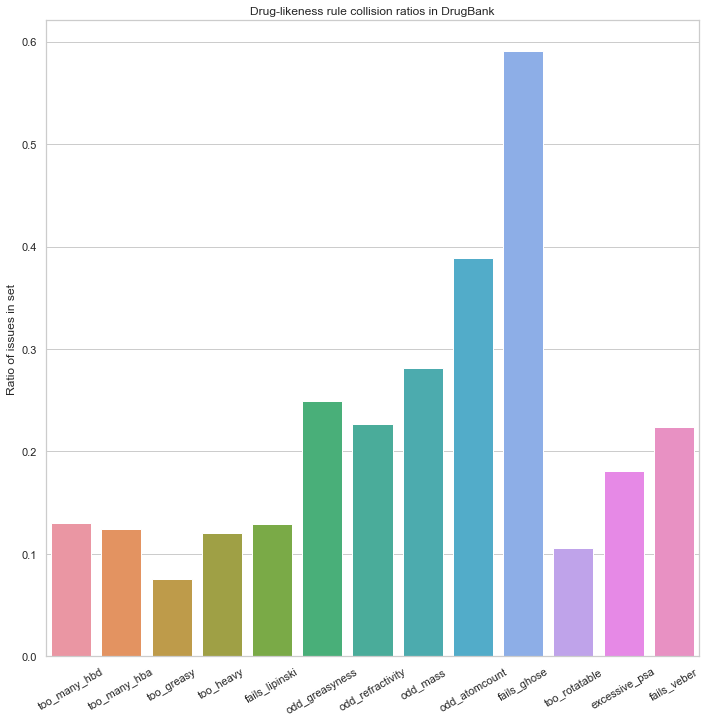

In [100]:
# let's visualize this monstrosity:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df_drugbank, ci=None)
    p.set_title("Drug-likeness rule collision ratios in DrugBank")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) # avoid ugly text clipping

## *Drugbank conclusion - Lepinski, Veber*
Apparently, known drugs from DrugBank aren't perfect either. It has less failures in the Lipinski filter, but Ghose and Veber filters stats are even worse than with the MTOR ligand set. Where MTOR has more problems with molecular refractivity and mass, DrugBank content seems to have relatively more issues with greasiness, raw atom count, rotatable bonds and polar surface area.

This demonstrates that the Lipinski and indeed all other similar filters should be used as they are intended: as rough outlines of druglike properties, not as an evangelium. They can help you identify the truly hopeless structures, but there is no need to thrash an otherwise promising molecule just because it violates one or two rules.

## Lead-likeness
During drug discovery, lipophilicity and molecular weight are often increased in order to improve the affinity and selectivity of the drug candidate. Hence it is often difficult to maintain drug-likeness (i.e., RO5 compliance) during hit and lead optimization. Hence it has been proposed that members of screening libraries from which hits are discovered should be biased toward lower molecular weight and lipophility so that medicinal chemists will have an easier time in delivering optimized drug development candidates that are also drug-like. Hence the rule of five has been extended to the rule of three (RO3) for defining lead-like compounds.

Source: https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five#Lead-like

In [101]:
#Lead-likeness filter

# logP less than 3
def too_greasy_leadlike(mol):
    return Descriptors.MolLogP(mol) > 3

# molecular mass less than 300 daltons
def too_heavy_leadlike(mol):
    return rdescriptors.CalcExactMolWt(mol) > 300

# no more than 3 hydrogen bond donors
def too_many_hbd_leadlike(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol) > 3

# no more than 3 hydrogen bond acceptors
def too_many_hba_leadlike(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 3

# no more than 3 rotatable bonds
def too_rotatable_leadlike(mol):
    return Chem.CalcNumRotatableBonds(mol) > 3

# Function - LeadLike violation
def ro5_violations_leadlike(mol):
    return sum([too_many_hbd_leadlike(mol), too_many_hba_leadlike(mol), too_many_hbd_leadlike(mol), too_greasy_leadlike(mol), too_rotatable_leadlike(mol)])

def violates_leadlike(mol):
    return ro5_violations_leadlike(mol) > 3

# df for MTOR, DrugBank and cytochrome P450
df_leadlike_mtor = pd.DataFrame(
    data={'set':'LeadLike MTOR',
          'too_greasy_lead': [too_greasy_leadlike(l) for l in mtor_ligands],
          'too_heavy_lead': [too_heavy_leadlike(l) for l in mtor_ligands],
          'too_many_hbd_lead': [too_many_hbd_leadlike(l) for l in mtor_ligands],
          'too_many_hba_lead': [too_many_hba_leadlike(l) for l in mtor_ligands],
          'too_rotatable_lead': [too_rotatable_leadlike(l) for l in mtor_ligands],
           'fails_leadlike': [violates_leadlike(l) for l in mtor_ligands],})

df_leadlike_drugbank = pd.DataFrame(
    data={'set':'LeadLike DrugBank',
          'too_greasy_lead': [too_greasy_leadlike(l) for l in drugs],
          'too_heavy_lead': [too_heavy_leadlike(l) for l in drugs],
          'too_many_hbd_lead': [too_many_hbd_leadlike(l) for l in drugs],
          'too_many_hba_lead': [too_many_hba_leadlike(l) for l in drugs],
          'too_rotatable_lead': [too_rotatable_leadlike(l) for l in drugs],
           'fails_leadlike': [violates_leadlike(l) for l in drugs],})

df_leadlike_cyt = pd.DataFrame(
    data={'set':'LeadLike Cytochrome P450',
          'too_greasy_lead': [too_greasy_leadlike(l) for l in cyt_ligands],
          'too_heavy_lead': [too_heavy_leadlike(l) for l in cyt_ligands],
          'too_many_hbd_lead': [too_many_hbd_leadlike(l) for l in cyt_ligands],
          'too_many_hba_lead': [too_many_hba_leadlike(l) for l in cyt_ligands],
          'too_rotatable_lead': [too_rotatable_leadlike(l) for l in cyt_ligands],
           'fails_leadlike': [violates_leadlike(l) for l in cyt_ligands],})

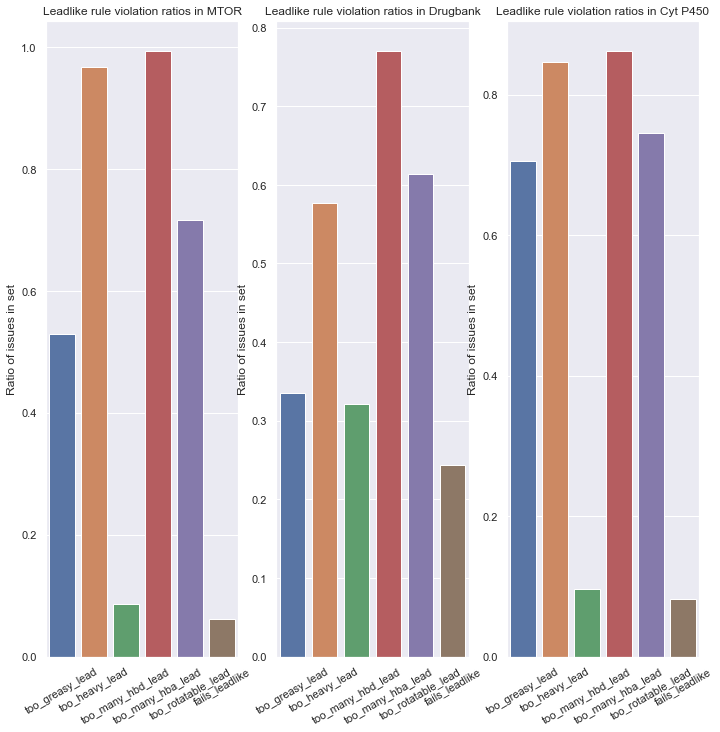

In [102]:
# Visualisation of LeadLike's violation (MTOR, Drugbank, Cytochtome P450)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=3)
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df_leadlike_mtor, ci=None, ax=axs[0])
    p.set_title("Leadlike rule violation ratios in MTOR")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30)
    
with sns.axes_style("whitegrid"):
    s = sns.barplot(data=df_leadlike_drugbank, ci=None, ax=axs[1])
    s.set_title("Leadlike rule violation ratios in Drugbank")
    s.set_ylabel("Ratio of issues in set")
    s.set_xticklabels(p.get_xticklabels(), rotation=30)
    
with sns.axes_style("whitegrid"):
    t = sns.barplot(data=df_leadlike_cyt, ci=None, ax=axs[2])
    t.set_title("Leadlike rule violation ratios in Cyt P450")
    t.set_ylabel("Ratio of issues in set")
    t.set_xticklabels(p.get_xticklabels(), rotation=30)

As it seen from the graph, over 20 % of ligands are failing leadlike violation in Drugbank due to higher proportion of hydrogen bonds and hydrohen bond acceptors. In both MTOR and cytochrome P450 dataset are the most influencing factors are higher molecular weight and higher number of hydrogen bond acceptors. For both dataset less than 10 % of all ligands violate more than one leadlike rule. 

In [103]:
# Leadlike violation MTOR, DrugBank and cytochrome P450
mtor_ro5_violations = [ro5_violations_leadlike(l) for l in mtor_ligands]
mtor_violates_leadlike = [violates_leadlike(l) for l in mtor_ligands]
print('MTOR: ', sum(mtor_ro5_violations),\
round(sum(mtor_ro5_violations)/len(mtor_ro5_violations),2), '%',\
sum(mtor_violates_leadlike),\
round(sum(mtor_violates_leadlike)/len(mtor_violates_leadlike),2), '%')

drugs_ro5_violations = [ro5_violations_leadlike(l) for l in drugs]
drugs_violates_leadlike = [violates_leadlike(l) for l in drugs]
print('DrugBank: ', sum(drugs_ro5_violations),\
round(sum(drugs_ro5_violations)/len(drugs_ro5_violations),2), '%',\
sum(drugs_violates_leadlike),\
round(sum(drugs_violates_leadlike)/len(drugs_violates_leadlike),2), '%')

cyt_ro5_violations = [ro5_violations_leadlike(l) for l in cyt_ligands]
cyt_violates_leadlike = [violates_leadlike(l) for l in cyt_ligands]
print('Cytochrome P450: ',sum(cyt_ro5_violations),\
round(sum(cyt_ro5_violations)/len(cyt_ro5_violations),2),'%',\
sum(cyt_violates_leadlike),\
round(sum(cyt_violates_leadlike)/len(cyt_violates_leadlike),2), '%')

MTOR:  11077 2.41 % 283 0.06 %
DrugBank:  16796 2.36 % 1731 0.24 %
Cytochrome P450:  14643 2.51 % 475 0.08 %


# Summary
## Lipinski's rule
* The overall amount of RO5 violations (for Lepinski rule) in the my data set seems to be 2608 (44 %). 
* 680 ligands (17%) violate more than one LRO5 rule, and thus fail the standard Lipinski filter.
* The majority of ligands in my dataset violate the Lipinski rule due to the higher molecular weight (over 500 kDa) and logP less than 5 (greasiness).
* In drugbank dataset over 10 %fails Lipinski's rule duu to the higher number of hydrogen acceptors and donors as well as excessive weight.
* In MTOR dataset, two most important factors for vialation of Lepinski's rule are a high number of hydrogen bond acceptors and excessive molecular weight.
## Ghose filter, Veber's rule
* According to Ghose filter, most of ligands in my dataset have bad molar refractivity and high mass.
* In drugbank dataset over 25% molecules violate Ghose rule due to  the issues with greasiness, raw atom count, rotatable bonds and polar surface area.
* Regarding to Veber's rule, my ligands do not have a large polar surface area, so only 5 % of all molecules fail this rule.
* In drugbank dataset Veber's rule shows worse results due to the excessive polar surface area.
* For comparison, MTOR dataset also fails Ghose filter on on bad molar refractivity (i.e. polarizability) and on the large size of the molecules.
## Leadlike violation
* In my dataset 475 molecules fails the LeadLike test (8.0%) due to higher molecular weight and higher hydrogen bond acceptor. The same pattern is observed for MTOR dataset. 
* In drugbank dataset 1731 (24.0%) molecules fails the LeadLike test. Most of ligands violate the rule due to the higher number of hydrogen bond acceptors and donors.